# Classifying images with a pretrained model

In this section we will learn how to use a pretrained model, to perform predictions without changing its parameters, specifically we will use a pretrained residual network model having 152 residual blocks.

Residual models are a generation of convnets proposed in 2016 which obtained the best results for the ILSRVC (originally regarding classifcation and localization on ImageNet dataset) competition for that year, since then a lot of its variations are getting proposed, you can see a full list of available pretrained models on the pytorch documentation website, along with the performace obtained by the model on the ImageNet test set.

The power of those residual model is given by the residual paths, which consists of a residual block's input value replicated and concatenated to its output, in a way that the model keeps a sort of track of what the orinal data contains. This fact permits the model to leaern better using the same number of parameters. More informations about the residual models can be found here:

https://arxiv.org/abs/1512.03385

Let's import our needed packages

In [1]:
import torch
from torch.utils import data

import numpy as np

from torchvision.datasets.mnist import FashionMNIST
from torchvision.models.resnet import resnet152
from torchvision import transforms, utils

nn = torch.nn
optim = torch.optim
Variable = torch.autograd.Variable
F = torch.nn.functional


from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

to get pretrained resnet, it is sufficient to pass **True** to the **pretrained** method parameter. It's VERY important to call **.eval()** on our method before using it for prediction, because otherwise we will obtain strange results. That's because inside our model, there are some layers which behaves differently during training and valuidation mode, and so by calling the **.eval()** method, thanks to how the nn.Module class, the call gets propagated to all the model'd submodules.

In [2]:
model = resnet152(pretrained=True).eval()

This model has been trained on ImageNet dataset, which consists of high-res images  for 1000 classes, so if we want to predict an image with the resnet model we need to map the class having the highest log probability, to the label name ('cat', 'dog', etc), so we just have to download the following json file and load it.

json imagenet classes, https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

In [3]:
import json
class_idx = json.load(open("../data/imagenet_class_index.json"))

Let's take an example image

In [4]:
img = Image.open('../data/imgs/img.jpg')
img = img.convert('RGB')

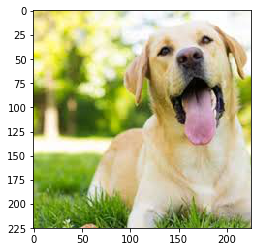

In [5]:
plt.imshow(img)

As you can see this is a picture of a dog of labrador breed, in order to pass the image to the model and get its prediction, we should apply the same preprocessing applied to the training image used for training the model with ImageNet images. Firstly, we need to apply the same normalization process applied to images form the training set, which means we need to subtract the pixels mean and divide by the pixels std, as eplained in the PyTorch documentaiton

http://pytorch.org/docs/master/torchvision/models.html


All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using **mean = [0.485, 0.456, 0.406]** and **std = [0.229, 0.224, 0.225]**. 

On the same page you can also see other model implementation and their accuracies on ImageNet testset.

Given that we should pass 224 images to the model we add a resize + crop transofrmation before creating the tensors and normalizing the image.


In [6]:
def preproc(x):
    x = img
    t = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    x = t(x)
    x = torch.Tensor(x).unsqueeze(0)
    x = Variable(x)
    return x


ok, now we have our preprocessing funciton ready and we can pass the image to the model in order to get its preditction for this image, so we pass the preprocessed image to the model, getting the model's log probabilities for the image belonging to each class (1000 classes), than we find the label having the highest probability, map its value to the class name and print it. We could actually have a master class too (dog, labrador) but this is a more simple map which just returns a sigle value.

In [7]:
output = model(preproc(img))
m, argm = output.data.squeeze().max(0)
class_id = argm[0]
print(output)
class_idx[str(class_id)]

Variable containing:
  0.9526   0.3957  -3.3898  ...   -1.4413   1.3864   0.6245
[torch.FloatTensor of size 1x1000]



['n02099712', 'Labrador_retriever']

Let's try with another image:

In [8]:
img = Image.open('../data/imgs/cat.jpg')
img = img.convert('RGB')

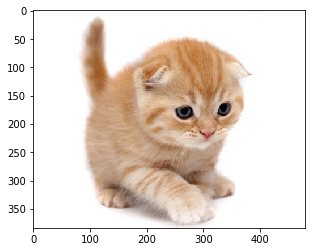

In [9]:
plt.imshow(img)

In [10]:
output = model(preproc(img))
m, argm = output.data.squeeze().max(0)
class_id = argm[0]
print(output)
class_idx[str(class_id)]

Variable containing:
-2.8816  0.4996 -3.6601  ...  -3.6811  2.7268  4.3930
[torch.FloatTensor of size 1x1000]



['n02123045', 'tabby']

"A tabby is any domestic cat" [wikipedia]
If we had the master class it would also gave us the 'cat' label